[该分类代码参考了这篇文章](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)

# 导入函数库

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 设置transform, 用于对数据集进行转换

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))  # 对应RGB三个通道，前者是mean,后者是std
])

# 加载训练集和测试集，同时进行shuffle, batch_size, transform等设置

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  # train训练集设置为True
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)  # shuffle训练集设置为True

testset = torchvision.datasets.CIFAR10(root='./data', train=False,  # train测试集设置为False
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)  # shuffle测试集设置为False

Files already downloaded and verified
Files already downloaded and verified


# 类别名称

In [4]:
classes = tuple(trainset.classes)

# 图片可视化函数

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # 因为一开始把数据缩放到了[-1,1]，所以这里需要还原到[0,1]，然后才能imshow
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # 因为Pytorch接受的是CHW，所以需要转换成HWC进行imshow
    plt.show()

# 对训练集图片进行可视化

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

## 查看数据是否缩放到了[-1,1]

In [7]:
torch.max(images)

tensor(1.)

In [8]:
torch.min(images)

tensor(-0.9608)

## 可视化训练集的第一个batch图片

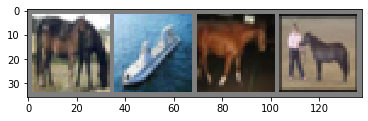

horse  ship horse horse


In [9]:
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 定义网络结构

此处我们使用2层卷积，３层全连接的网络

## 定义一个网络类，取名Net

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 输入3通道，输出6通道，kernel_size=5
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 输出x的shape=[batch_size, C, H, W]
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)  # 因为输出的output feature map不是二维的，所以需要reshape，这里的.view就是这个作用
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)   # 返回logits
        return x

## 声明一个网络实例

In [11]:
net = Net()

## 查看网络结构

In [12]:
net.modules

<bound method Module.modules of Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

In [13]:
net.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

## 查看网络处于eval还是training状态

In [14]:
net.training

True

# 定义损失函数和优化器

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  # 通过net.parameters()把所有trainable的参数都传入优化器里

# 开始训练网络，epoch设置为2，并输出损失值

In [16]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()  # 对梯度进行清零
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)  # 计算损失值
        loss.backward()  # 反向传播
        optimizer.step()  # 梯度更新
        
        running_loss += loss.item() # 此处的loss值是单一样本的损失值,而不是mini-batch的，因为取了均值
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.216
[1,  4000] loss: 1.886
[1,  6000] loss: 1.691
[1,  8000] loss: 1.564
[1, 10000] loss: 1.531
[1, 12000] loss: 1.474
[2,  2000] loss: 1.420
[2,  4000] loss: 1.409
[2,  6000] loss: 1.374
[2,  8000] loss: 1.346
[2, 10000] loss: 1.332
[2, 12000] loss: 1.308
Finished Training


# 保存模型权重

这里有个不错的解释: In Pytorch, the learnable parameters(weights and biases) of an torch.nn.Module model are contained in the model's parameters(accessed with model.parameters()). A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor.Note that only layers with learnable parameters(convolutional layers, linear layers) and registered buffers(batchnorm's running_mean) have entries in the model's state_dict. Optimizer objects(torch.optim) also have a state_dict, which contains information about the opimizer's state, as well as the hyperparameters used. Because state_dict objects are Python dictionaries, they can be easily saved, updated, altered, and restored, adding a great deal of modularity to PyTorch models and optimizers

In [17]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# 对测试集进行预测

## 可视化测试集的图片

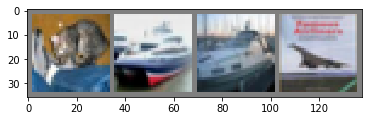

GroundTruth:    cat  ship  ship airplane


In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 声明一个类实例，并从.pth加载模型

因为网络里不包含dropout等，所以这里网络的状态直接是training也没事

In [19]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 对一个batch的测试集图片进行预测

In [20]:
outputs = net(images)

In [21]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship  ship


## 在10000张测试集上的准确率

计算公式和下面这个理解很类似: Accuracy = (TP + TN) / (TP + TN + FP + FN)

In [22]:
correct = 0
total = 0
with torch.no_grad():  # 推断的时候不需要计算梯度
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


## 在每个类别上的准确率

计算公式和下面这个理解很类似: Recall = TP / (TP + FN)

In [23]:
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 53 %
Accuracy of automobile : 69 %
Accuracy of  bird : 37 %
Accuracy of   cat : 32 %
Accuracy of  deer : 45 %
Accuracy of   dog : 52 %
Accuracy of  frog : 80 %
Accuracy of horse : 58 %
Accuracy of  ship : 71 %
Accuracy of truck : 55 %
